# Imports y configuraciones básicas

Algunos imports que se utilizarán en el resto del notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bwb.distributions import *
from bwb.utils import plot_list_of_draws, plot_histogram_from_points

import pandas as pd
import itertools

In [2]:
# import logging
# log = logging.getLogger("bwb.distributions")
# log.setLevel(logging.DEBUG)

Importamos los datos del archivo de Google Cloud

In [3]:
data = np.load(r"..\data\face.npy")
data.shape

(161666, 784)

Haremos dos listas de caritas: una sin modificación, y otra con modificación.

In [4]:
%%time

CEIL = 50
n_faces = len(data)
rng = np.random.default_rng(42)


# Builder para hacer las caritas
dist_draw_builder = DistributionDrawBuilder(
    seed=rng,
)

# Conjunto de caritas originales (distintos soportes)
faces_original = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_original.append(dd_arr)
    
    
# Conjuntos de caritas con soporte no-nulo
dist_draw_builder.set_ceil(CEIL)
    
faces_modified = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_modified.append(dd_arr)
    
len(faces_original), len(faces_modified)

CPU times: total: 9.55 s
Wall time: 9.52 s


(161666, 161666)

`faces_original` son las caritas sin modificar el soporte, mientras que `faces_modified` es con los que tiene soporte no-nulo.

Obtendremos la data $D = \{x_i\}_{i=1}^{n}\subseteq\mathcal{X}^n$, y probaremos los métodos para distintos valores de $n$.

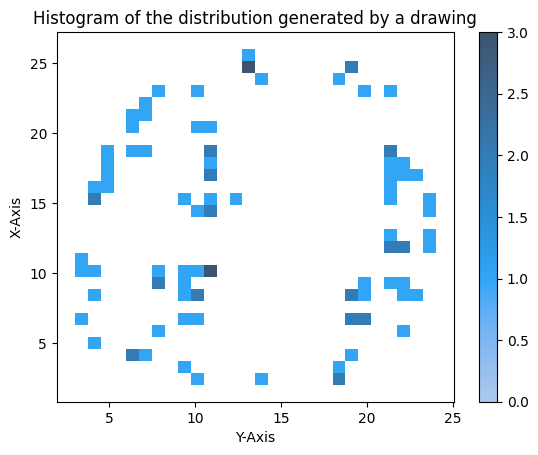

In [5]:
first_face = DistributionDraw.fromarray(
    255 - data[0, :].reshape(28, 28),
    seed=42
)

x = first_face.rvs(size=100)

plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

In [6]:
# Tiempo de cálculo del caché

De forma implícita, las clases `MetropolisPosteriorPiN` y `GibbsPosteriorPiN` hacen un pre-procesamiento para calcular a modo de caché todas las verosimilitudes. En este notebook se calcularán los tiempos de iniciación para calcular este caché, tanto para cada uno de los diferentes métodos como para la lista de conjunto de caritas originales y modificadas.

In [7]:
%%time
# %%script false --no-raise-error


def fmt_avg_stdev(avg, stdev):
    return f"{avg:.4f} ± {stdev:.4f}"


resume_df = pd.DataFrame()
resume_df.index.name = "n"

n_list = [5, 25, 50, 100]

for n in n_list:
    kwargs = dict(data=x[:n], models=faces_original, seed=rng)
    
    print(f"Metropolis Original: {n = }")
    result = %timeit -o MetropolisPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time M. original [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
    print(f"Gibbs Original: {n = }")
    result = %timeit -o GibbsPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time G. original [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
    kwargs["models"] = faces_modified
    
    print(f"Metropolis Modified: {n = }")
    result = %timeit -o MetropolisPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time M. modified [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
    print(f"Gibbs Modified: {n = }")
    result = %timeit -o GibbsPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time G. modified [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
print(resume_df.to_html())
print("="*20)
print(resume_df.to_latex())

Metropolis Original: n = 5
346 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Original: n = 5
329 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Metropolis Modified: n = 5
631 ms ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Modified: n = 5
625 ms ± 7.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Metropolis Original: n = 25
357 ms ± 8.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Original: n = 25
355 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Metropolis Modified: n = 25
2.51 s ± 57.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Modified: n = 25
2.7 s ± 208 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Metropolis Original: n = 50
381 ms ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Original: n = 50
370 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Metropolis Modified: n = 50
5.21 s ± 323 ms per loop (mean ± std. dev. of 7

C:\Users\asoln\PycharmProjects\PersonalProjects\Bayesian-Learning-with-Wasserstein-Barycenters\bwb\distributions.py:267: UserWarning: The likelihood support has only one element.
  warnings.warn("The likelihood support has only one element.")


358 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Original: n = 100


C:\Users\asoln\PycharmProjects\PersonalProjects\Bayesian-Learning-with-Wasserstein-Barycenters\bwb\distributions.py:267: UserWarning: The likelihood support has only one element.
  warnings.warn("The likelihood support has only one element.")


350 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Metropolis Modified: n = 100
10.3 s ± 962 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Modified: n = 100
14.1 s ± 4.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Time M. original [seg]</th>
      <th>Time G. original [seg]</th>
      <th>Time M. modified [seg]</th>
      <th>Time G. modified [seg]</th>
    </tr>
    <tr>
      <th>n</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.3463 ± 0.0180</td>
      <td>0.3294 ± 0.0146</td>
      <td>0.6310 ± 0.0260</td>
      <td>0.6249 ± 0.0078</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.3573 ± 0.0087</td>
      <td>0.3547 ± 0.0105</td>
      <td>2.5085 ± 0.0575</td>
      <td>2.6995 ± 0.2080</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.3815

<timed exec>:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [8]:
print(resume_df.to_latex(
    label="tab:comparacion-tiempos-mcmc", 
    caption=("Comparación de los tiempos de ejecución de cuatro MCMC en comparación con la "
             "cantidad de coordenadas proporcionadas. la primera es con el "
             "método Metropolis con datos originales, la segunda es con Gibbs Sampler con "
             "datos originales, la tercera es con Metropolis con datos modificados, y la "
             "cuarta es Gibbs Sampler con datos modificados.")))

\begin{table}
\centering
\caption{Comparación de los tiempos de ejecución de cuatro MCMC en comparación con la cantidad de coordenadas proporcionadas. la primera es con el método Metropolis con datos originales, la segunda es con Gibbs Sampler con datos originales, la tercera es con Metropolis con datos modificados, y la cuarta es Gibbs Sampler con datos modificados.}
\label{tab:comparacion-tiempos-mcmc}
\begin{tabular}{lllll}
\toprule
{} & Time M. original [seg] & Time G. original [seg] & Time M. modified [seg] & Time G. modified [seg] \\
n   &                        &                        &                        &                        \\
\midrule
5   &        0.3463 ± 0.0180 &        0.3294 ± 0.0146 &        0.6310 ± 0.0260 &        0.6249 ± 0.0078 \\
25  &        0.3573 ± 0.0087 &        0.3547 ± 0.0105 &        2.5085 ± 0.0575 &        2.6995 ± 0.2080 \\
50  &        0.3815 ± 0.0282 &        0.3705 ± 0.0122 &        5.2115 ± 0.3233 &        4.9752 ± 0.0648 \\
100 &        0.35

C:\Users\asoln\AppData\Local\Temp\ipykernel_22944\2325931836.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(resume_df.to_latex(


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Time M. original [seg]</th>
      <th>Time G. original [seg]</th>
      <th>Time M. modified [seg]</th>
      <th>Time G. modified [seg]</th>
    </tr>
    <tr>
      <th>n</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.3463 ± 0.0180</td>
      <td>0.3294 ± 0.0146</td>
      <td>0.6310 ± 0.0260</td>
      <td>0.6249 ± 0.0078</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.3573 ± 0.0087</td>
      <td>0.3547 ± 0.0105</td>
      <td>2.5085 ± 0.0575</td>
      <td>2.6995 ± 0.2080</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.3815 ± 0.0282</td>
      <td>0.3705 ± 0.0122</td>
      <td>5.2115 ± 0.3233</td>
      <td>4.9752 ± 0.0648</td>
    </tr>
    <tr>
      <th>100</th>
      <td>0.3579 ± 0.0166</td>
      <td>0.3499 ± 0.0216</td>
      <td>10.2836 ± 0.9616</td>
      <td>14.1060 ± 4.4000</td>
    </tr>
  </tbody>
</table>

Ahora queremos ver el número de muestras que se samplean de las distribuciones y el tiempo que se demora, como también el tiempo promedio que se demora por cada iteración y por cada método

In [9]:
# Tables
m_num_samples_original = pd.DataFrame()
m_total_time_original = pd.DataFrame()

g_num_samples_original = pd.DataFrame()
g_total_time_original = pd.DataFrame()

m_num_samples_modified = pd.DataFrame()
m_total_time_modified = pd.DataFrame()

g_num_samples_modified = pd.DataFrame()
g_total_time_modified = pd.DataFrame()

df_list = [m_num_samples_original, m_total_time_original,
           g_num_samples_original, g_total_time_original,
           m_num_samples_modified, m_total_time_modified,
           g_num_samples_modified, g_total_time_modified]

for df in df_list:
    df.index.name = "n \ k"

In [10]:
%%time
# %%script false --no-raise-error

# n-k lists
n_list = [5, 25, 50, 75]
k_list = [1, 50, 100, 500, 1000, 2500]


# Iterate over n/k
for n, k in itertools.product(n_list, k_list):
    kwargs = dict(data=x[:n], models=faces_original, seed=rng)
    
    
    print(f"Metropolis original {n = }, {k = }")
    mcmc = AlternativeMetropolisPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    m_num_samples_original.loc[n, k] = len(mcmc.counter)
    m_total_time_original.loc[n, k] = f"{result.average:.4f}"
    
    
    print(f"Gibbs original {n = }, {k = }")
    mcmc = AlternativeGibbsPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    g_num_samples_original.loc[n, k] = len(mcmc.counter)
    g_total_time_original.loc[n, k] = f"{result.average:.4f}"
    
    
    
    kwargs["models"] = faces_modified
    
    print(f"Metropolis modified {n = }, {k = }")
    mcmc = AlternativeMetropolisPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    m_num_samples_modified.loc[n, k] = len(mcmc.counter)
    m_total_time_modified.loc[n, k] = f"{result.average:.4f}"
    
    
    print(f"Gibbs modified {n = }, {k = }")
    mcmc = AlternativeGibbsPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    g_num_samples_modified.loc[n, k] = len(mcmc.counter)
    g_total_time_modified.loc[n, k] = f"{result.average:.4f}"
    
#     break

Metropolis original n = 5, k = 1
5.58 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.005578000040259212
Gibbs original n = 5, k = 1
2.24 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.002235999971162528
Metropolis modified n = 5, k = 1
15.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.015244500013068318
Gibbs modified n = 5, k = 1
33.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.033250699983909726
Metropolis original n = 5, k = 50
66.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 8
result.average = 0.06629499996779487
Gibbs original n = 5, k = 50
176 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 49
result.average = 0.17601140000624582
Metropolis modified n = 5, k = 50
873 ms ± 0 ns per loop (mean ± st

2.88 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.002884400018956512
Metropolis modified n = 50, k = 50
843 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 6
result.average = 0.8431379999965429
Gibbs modified n = 50, k = 50
816 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 2
result.average = 0.8157911999733187
Metropolis original n = 50, k = 100
6.93 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 2
result.average = 0.006931299983989447
Gibbs original n = 50, k = 100
4.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.004804899974260479
Metropolis modified n = 50, k = 100
1.92 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 5
result.average = 1.9197226000251248
Gibbs modified n = 50, k = 100
1.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each

C:\Users\asoln\PycharmProjects\PersonalProjects\Bayesian-Learning-with-Wasserstein-Barycenters\bwb\distributions.py:267: UserWarning: The likelihood support has only one element.
  warnings.warn("The likelihood support has only one element.")


50.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 5.0200033001601696e-05
Gibbs original n = 75, k = 1


C:\Users\asoln\PycharmProjects\PersonalProjects\Bayesian-Learning-with-Wasserstein-Barycenters\bwb\distributions.py:267: UserWarning: The likelihood support has only one element.
  warnings.warn("The likelihood support has only one element.")


31.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 3.1400006264448166e-05
Metropolis modified n = 75, k = 1
14.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.014545799989718944
Gibbs modified n = 75, k = 1
15.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.015747299999929965
Metropolis original n = 75, k = 50


C:\Users\asoln\PycharmProjects\PersonalProjects\Bayesian-Learning-with-Wasserstein-Barycenters\bwb\distributions.py:267: UserWarning: The likelihood support has only one element.
  warnings.warn("The likelihood support has only one element.")


595 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.0005947999889031053
Gibbs original n = 75, k = 50
544 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.0005443000118248165
Metropolis modified n = 75, k = 50
826 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 4
result.average = 0.8264704000321217
Gibbs modified n = 75, k = 50
772 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 2
result.average = 0.772022899996955
Metropolis original n = 75, k = 100
819 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.0008188000065274537
Gibbs original n = 75, k = 100
694 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.0006938999867998064
Metropolis modified n = 75, k = 100
1.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop e

In [19]:
df = m_num_samples_original.astype(int)
# print(df.to_html())
print("="*20)
print(df.to_latex(
    label="tab:m_num_samples_original",
    caption=("Número de muestras distintas para el caso de MCMC Metropolis usando los datos originales."
             " La columna indica el número de"
             " veces que se muestrea la MCMC y fila indica el número de datos proporcionados.")
)
)
df

\begin{table}
\centering
\caption{Número de muestras distintas para el caso de MCMC Metropolis usando los datos originales. La columna indica el número de veces que se muestrea la MCMC y fila indica el número de datos proporcionados.}
\label{tab:m_num_samples_original}
\begin{tabular}{lrrrrrr}
\toprule
{} &  1    &  50   &  100  &  500  &  1000 &  2500 \\
n \textbackslash  k &       &       &       &       &       &       \\
\midrule
5     &     1 &     8 &    27 &    79 &   190 &   427 \\
25    &     1 &    10 &     2 &     6 &    12 &     6 \\
50    &     1 &     2 &     2 &     2 &     2 &     1 \\
75    &     1 &     1 &     1 &     1 &     1 &     1 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\asoln\AppData\Local\Temp\ipykernel_22944\2334706018.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


,1,50,100,500,1000,2500
n \ k,,,,,,
5,1,8,27,79,190,427
25,1,10,2,6,12,6
50,1,2,2,2,2,1
75,1,1,1,1,1,1


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>12.0</td>
      <td>20.0</td>
      <td>101.0</td>
      <td>195.0</td>
      <td>441.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>3.0</td>
      <td>6.0</td>
      <td>3.0</td>
      <td>5.0</td>
      <td>16.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
  </tbody>
</table>

In [12]:
df = m_total_time_original
# print(df.to_html())
print("="*20)
print(df.to_latex(
    label="tab:m_total_time_original",
    caption=("Tiempo total en segundos para el caso de MCMC Metropolis usando los datos originales."
             " La columna indica el número de"
             " veces que se muestrea la MCMC y fila indica el número de datos proporcionados.")
))
df

\begin{table}
\centering
\caption{Tiempo total en segundos para el caso de MCMC Metropolis usando los datos originales. La columna indica el número de veces que se muestrea la MCMC y fila indica el número de datos proporcionados.}
\label{tab:m_total_time_original}
\begin{tabular}{lllllll}
\toprule
{} &    1    &    50   &    100  &    500  &    1000 &    2500 \\
n \textbackslash  k &         &         &         &         &         &         \\
\midrule
5     &  0.0056 &  0.0663 &  0.1407 &  0.5564 &  1.1701 &  2.7845 \\
25    &  0.0013 &  0.0046 &  0.0066 &  0.0323 &  0.0778 &  0.1732 \\
50    &  0.0003 &  0.0037 &  0.0069 &  0.0280 &  0.0551 &  0.1406 \\
75    &  0.0001 &  0.0006 &  0.0008 &  0.0034 &  0.0127 &  0.0199 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\asoln\AppData\Local\Temp\ipykernel_22944\3367027752.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


,1,50,100,500,1000,2500
n \ k,,,,,,
5,0.0056,0.0663,0.1407,0.5564,1.1701,2.7845
25,0.0013,0.0046,0.0066,0.0323,0.0778,0.1732
50,0.0003,0.0037,0.0069,0.0280,0.0551,0.1406
75,0.0001,0.0006,0.0008,0.0034,0.0127,0.0199


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0014</td>
      <td>0.0511</td>
      <td>0.1043</td>
      <td>0.6535</td>
      <td>1.1080</td>
      <td>2.9345</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0024</td>
      <td>0.0032</td>
      <td>0.0116</td>
      <td>0.0331</td>
      <td>0.0811</td>
      <td>0.1687</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0002</td>
      <td>0.0043</td>
      <td>0.0136</td>
      <td>0.0345</td>
      <td>0.0570</td>
      <td>0.1401</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0001</td>
      <td>0.0007</td>
      <td>0.0008</td>
      <td>0.0037</td>
      <td>0.0071</td>
      <td>0.0177</td>
    </tr>
  </tbody>
</table>

In [20]:
df = g_num_samples_original.astype(int)
# print(df.to_html())
print("="*20)
print(df.to_latex(
    label="tab:g_num_samples_original",
    caption=("Número de muestras distintas para el caso de MCMC Gibbs Sampler usando los datos originales."
             " La columna indica el número de"
             " veces que se muestrea la MCMC y fila indica el número de datos proporcionados.")
))
df

\begin{table}
\centering
\caption{Número de muestras distintas para el caso de MCMC Gibbs Sampler usando los datos originales. La columna indica el número de veces que se muestrea la MCMC y fila indica el número de datos proporcionados.}
\label{tab:g_num_samples_original}
\begin{tabular}{lrrrrrr}
\toprule
{} &  1    &  50   &  100  &  500  &  1000 &  2500 \\
n \textbackslash  k &       &       &       &       &       &       \\
\midrule
5     &     1 &    49 &    94 &   408 &   725 &  1404 \\
25    &     1 &     2 &     5 &     5 &     9 &    11 \\
50    &     1 &     1 &     1 &     2 &     1 &     1 \\
75    &     1 &     1 &     1 &     1 &     1 &     1 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\asoln\AppData\Local\Temp\ipykernel_22944\3436424398.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


,1,50,100,500,1000,2500
n \ k,,,,,,
5,1,49,94,408,725,1404
25,1,2,5,5,9,11
50,1,1,1,2,1,1
75,1,1,1,1,1,1


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>49.0</td>
      <td>97.0</td>
      <td>403.0</td>
      <td>738.0</td>
      <td>1405.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>5.0</td>
      <td>4.0</td>
      <td>5.0</td>
      <td>13.0</td>
      <td>15.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
  </tbody>
</table>

In [14]:
df = g_total_time_original
# print(df.to_html())
print("="*20)
print(df.to_latex(
    label="tab:g_total_time_original",
    caption=("Tiempo total en segundos para el caso de MCMC Gibbs Sampler usando los datos originales."
             " La columna indica el número de"
             " veces que se muestrea la MCMC y fila indica el número de datos proporcionados.")
))
df

\begin{table}
\centering
\caption{Tiempo total en segundos para el caso de MCMC Gibbs Sampler usando los datos originales. La columna indica el número de veces que se muestrea la MCMC y fila indica el número de datos proporcionados.}
\label{tab:g_total_time_original}
\begin{tabular}{lllllll}
\toprule
{} &    1    &    50   &    100  &    500  &    1000 &    2500 \\
n \textbackslash  k &         &         &         &         &         &         \\
\midrule
5     &  0.0022 &  0.1760 &  0.1289 &  0.6269 &  1.1333 &  3.1199 \\
25    &  0.0002 &  0.0052 &  0.0052 &  0.0292 &  0.0525 &  0.1609 \\
50    &  0.0001 &  0.0029 &  0.0048 &  0.0222 &  0.0643 &  0.1111 \\
75    &  0.0000 &  0.0005 &  0.0007 &  0.0057 &  0.0075 &  0.0230 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\asoln\AppData\Local\Temp\ipykernel_22944\2986624604.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


,1,50,100,500,1000,2500
n \ k,,,,,,
5,0.0022,0.1760,0.1289,0.6269,1.1333,3.1199
25,0.0002,0.0052,0.0052,0.0292,0.0525,0.1609
50,0.0001,0.0029,0.0048,0.0222,0.0643,0.1111
75,0.0000,0.0005,0.0007,0.0057,0.0075,0.0230


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0012</td>
      <td>0.0610</td>
      <td>0.1108</td>
      <td>0.6387</td>
      <td>1.0874</td>
      <td>3.2232</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0006</td>
      <td>0.0029</td>
      <td>0.0071</td>
      <td>0.0332</td>
      <td>0.0568</td>
      <td>0.1391</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0002</td>
      <td>0.0043</td>
      <td>0.0054</td>
      <td>0.0243</td>
      <td>0.0459</td>
      <td>0.1150</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0000</td>
      <td>0.0004</td>
      <td>0.0007</td>
      <td>0.0045</td>
      <td>0.0075</td>
      <td>0.0179</td>
    </tr>
  </tbody>
</table>

In [21]:
df = m_num_samples_modified.astype(int)
# print(df.to_html())
print("="*20)
print(df.to_latex(
    label="tab:m_num_samples_modified",
    caption=("Númnero de muestras distintas para el caso de MCMC Metropolis usando los datos modificados."
             " La columna indica el número de"
             " veces que se muestrea la MCMC y fila indica el número de datos proporcionados.")
))
df

\begin{table}
\centering
\caption{Númnero de muestras distintas para el caso de MCMC Metropolis usando los datos modificados. La columna indica el número de veces que se muestrea la MCMC y fila indica el número de datos proporcionados.}
\label{tab:m_num_samples_modified}
\begin{tabular}{lrrrrrr}
\toprule
{} &  1    &  50   &  100  &  500  &  1000 &  2500 \\
n \textbackslash  k &       &       &       &       &       &       \\
\midrule
5     &     1 &    12 &    24 &   134 &   280 &   731 \\
25    &     1 &     4 &    15 &    23 &    32 &    46 \\
50    &     1 &     6 &     5 &    11 &    12 &     9 \\
75    &     1 &     4 &     6 &     9 &     7 &    17 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\asoln\AppData\Local\Temp\ipykernel_22944\519418380.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


,1,50,100,500,1000,2500
n \ k,,,,,,
5,1,12,24,134,280,731
25,1,4,15,23,32,46
50,1,6,5,11,12,9
75,1,4,6,9,7,17


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>11.0</td>
      <td>13.0</td>
      <td>87.0</td>
      <td>203.0</td>
      <td>752.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>7.0</td>
      <td>9.0</td>
      <td>1.0</td>
      <td>17.0</td>
      <td>15.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>5.0</td>
      <td>8.0</td>
      <td>8.0</td>
      <td>12.0</td>
      <td>17.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>8.0</td>
      <td>9.0</td>
      <td>14.0</td>
      <td>7.0</td>
      <td>9.0</td>
    </tr>
  </tbody>
</table>

In [16]:
df = m_total_time_modified
# print(df.to_html())
print("="*20)
print(df.to_latex(
    label="tab:m_total_time_modified",
    caption=("Tiempo total en segundos para el caso de MCMC Metropolis usando los datos modificados."
             " La columna indica el número de"
             " veces que se muestrea la MCMC y fila indica el número de datos proporcionados.")
))
df

\begin{table}
\centering
\caption{Tiempo total en segundos para el caso de MCMC Metropolis usando los datos modificados. La columna indica el número de veces que se muestrea la MCMC y fila indica el número de datos proporcionados.}
\label{tab:m_total_time_modified}
\begin{tabular}{lllllll}
\toprule
{} &    1    &    50   &    100  &    500  &     1000 &     2500 \\
n \textbackslash  k &         &         &         &         &          &          \\
\midrule
5     &  0.0152 &  0.8731 &  1.8865 &  8.9994 &  17.2393 &  41.6296 \\
25    &  0.0161 &  0.7973 &  1.9746 &  8.3121 &  17.1081 &  41.4537 \\
50    &  0.0159 &  0.8431 &  1.9197 &  8.2536 &  16.5341 &  43.1729 \\
75    &  0.0145 &  0.8265 &  1.6675 &  8.4470 &  16.5783 &  43.1614 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\asoln\AppData\Local\Temp\ipykernel_22944\350071423.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


,1,50,100,500,1000,2500
n \ k,,,,,,
5,0.0152,0.8731,1.8865,8.9994,17.2393,41.6296
25,0.0161,0.7973,1.9746,8.3121,17.1081,41.4537
50,0.0159,0.8431,1.9197,8.2536,16.5341,43.1729
75,0.0145,0.8265,1.6675,8.4470,16.5783,43.1614


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0162</td>
      <td>0.8749</td>
      <td>1.6367</td>
      <td>8.2336</td>
      <td>17.0771</td>
      <td>41.5876</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0155</td>
      <td>0.9267</td>
      <td>1.6738</td>
      <td>8.7581</td>
      <td>16.6361</td>
      <td>41.8724</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0155</td>
      <td>0.8342</td>
      <td>2.3497</td>
      <td>8.8038</td>
      <td>18.3098</td>
      <td>41.6662</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0151</td>
      <td>0.8028</td>
      <td>1.6917</td>
      <td>8.4317</td>
      <td>16.3477</td>
      <td>44.5841</td>
    </tr>
  </tbody>
</table>

In [22]:
df = g_num_samples_modified.astype(int)
# print(df.to_html())
print("="*20)
print(df.to_latex(
    label="tab:g_num_samples_modified",
    caption=("Número de muestras distintas para el caso de MCMC Gibbs Sampler usando los datos modificados."
             " La columna indica el número de"
             " veces que se muestrea la MCMC y fila indica el número de datos proporcionados.")
))
df

\begin{table}
\centering
\caption{Número de muestras distintas para el caso de MCMC Gibbs Sampler usando los datos modificados. La columna indica el número de veces que se muestrea la MCMC y fila indica el número de datos proporcionados.}
\label{tab:g_num_samples_modified}
\begin{tabular}{lrrrrrr}
\toprule
{} &  1    &  50   &  100  &  500  &  1000 &  2500 \\
n \textbackslash  k &       &       &       &       &       &       \\
\midrule
5     &     1 &    50 &   100 &   497 &   971 &  2356 \\
25    &     1 &    33 &    62 &   211 &   387 &   701 \\
50    &     1 &     2 &     2 &     3 &     2 &     4 \\
75    &     1 &     2 &     2 &     2 &     2 &     2 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\asoln\AppData\Local\Temp\ipykernel_22944\4240926325.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


,1,50,100,500,1000,2500
n \ k,,,,,,
5,1,50,100,497,971,2356
25,1,33,62,211,387,701
50,1,2,2,3,2,4
75,1,2,2,2,2,2


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>49.0</td>
      <td>100.0</td>
      <td>496.0</td>
      <td>970.0</td>
      <td>2364.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>40.0</td>
      <td>66.0</td>
      <td>228.0</td>
      <td>372.0</td>
      <td>654.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>3.0</td>
      <td>3.0</td>
      <td>4.0</td>
      <td>4.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
    </tr>
  </tbody>
</table>

In [18]:
df = g_total_time_modified
# print(df.to_html())
print("="*20)
print(df.to_latex(
    label="tab:g_total_time_modified",
    caption=("Tiempo total en segundos para el caso de MCMC Gibbs Sampler usando los datos modificados."
             " La columna indica el número de"
             " veces que se muestrea la MCMC y fila indica el número de datos proporcionados.")
))
df

\begin{table}
\centering
\caption{Tiempo total en segundos para el caso de MCMC Gibbs Sampler usando los datos modificados. La columna indica el número de veces que se muestrea la MCMC y fila indica el número de datos proporcionados.}
\label{tab:g_total_time_modified}
\begin{tabular}{lllllll}
\toprule
{} &    1    &    50   &    100  &    500  &     1000 &     2500 \\
n \textbackslash  k &         &         &         &         &          &          \\
\midrule
5     &  0.0333 &  0.8698 &  2.1256 &  9.0401 &  20.5888 &  48.4803 \\
25    &  0.0154 &  0.8067 &  1.6596 &  8.1290 &  16.4355 &  40.5374 \\
50    &  0.0152 &  0.8158 &  1.6046 &  8.0612 &  15.9924 &  40.4206 \\
75    &  0.0157 &  0.7720 &  1.5663 &  7.9810 &  15.9372 &  41.5903 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\asoln\AppData\Local\Temp\ipykernel_22944\877583634.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


,1,50,100,500,1000,2500
n \ k,,,,,,
5,0.0333,0.8698,2.1256,9.0401,20.5888,48.4803
25,0.0154,0.8067,1.6596,8.1290,16.4355,40.5374
50,0.0152,0.8158,1.6046,8.0612,15.9924,40.4206
75,0.0157,0.7720,1.5663,7.9810,15.9372,41.5903


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0165</td>
      <td>0.8765</td>
      <td>1.6155</td>
      <td>8.8067</td>
      <td>17.6119</td>
      <td>48.1437</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0161</td>
      <td>1.0321</td>
      <td>1.7492</td>
      <td>8.1357</td>
      <td>15.9913</td>
      <td>45.4067</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0155</td>
      <td>0.8066</td>
      <td>1.6997</td>
      <td>8.4641</td>
      <td>16.3566</td>
      <td>40.3777</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0160</td>
      <td>0.8029</td>
      <td>1.5783</td>
      <td>7.9070</td>
      <td>15.9652</td>
      <td>40.1593</td>
    </tr>
  </tbody>
</table>